# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd

from vivace.backtest import (BacktestEngine, Strategy, Weighting, InstrumentDef,
                             Performance, signal, processing, rebase, PnLType)
from vivace.backtest.engine import long_only_returns

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

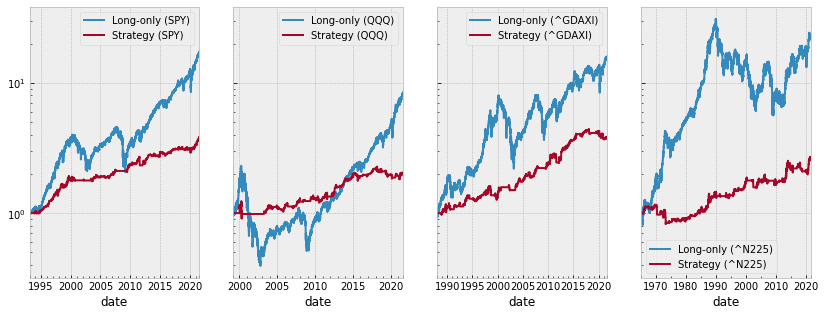

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.096380,0.045454,0.091762,0.030797,0.079191,0.038604,0.052764,0.016151
Annualised vol,0.184476,0.068893,0.272300,0.094400,0.218977,0.079974,0.195842,0.067715
Sharpe ratio,0.522452,0.659775,0.336989,0.326242,0.361638,0.482701,0.269422,0.238520
Max drawdown,0.551894,0.140756,0.829639,0.265982,0.726848,0.217462,0.818712,0.292850
Calmar ratio,0.174634,0.322928,0.110605,0.115787,0.108951,0.177519,0.064448,0.055152
Skewness,-0.051624,-1.127289,0.239007,1.686329,-0.131583,-1.967913,-0.199160,-4.080508
Kurtosis,12.684303,47.437242,7.555622,88.391728,6.849772,75.985057,9.722398,166.585317
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.128281,-0.246190,-0.246190,-0.233039,-0.131434,-0.243342,-0.149009


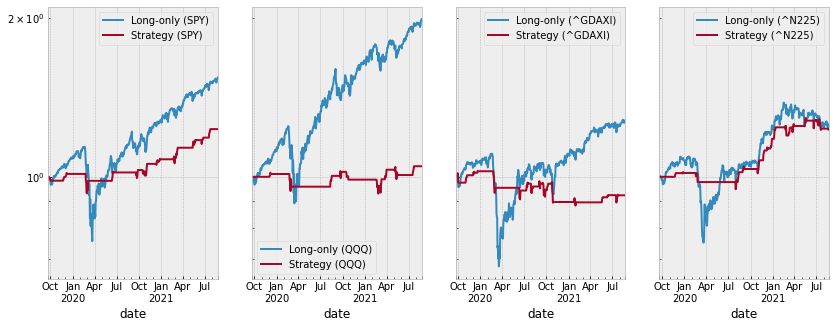

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

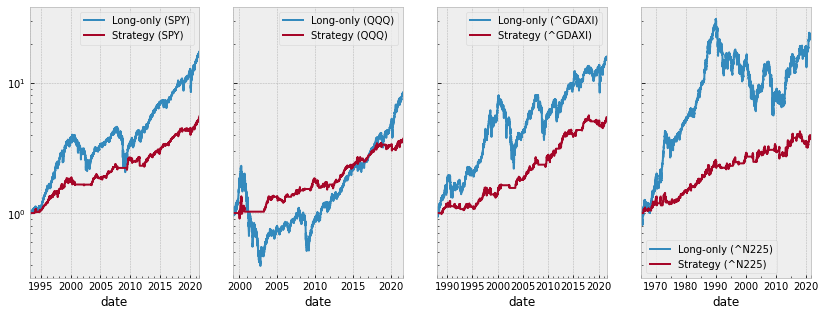

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.096380,0.057724,0.091762,0.056456,0.079191,0.048595,0.052764,0.022904
Annualised vol,0.184476,0.080355,0.272300,0.114879,0.218977,0.088285,0.195842,0.085016
Sharpe ratio,0.522452,0.718365,0.336989,0.491439,0.361638,0.550436,0.269422,0.269411
Max drawdown,0.551894,0.160132,0.829639,0.265982,0.726848,0.201483,0.818712,0.251076
Calmar ratio,0.174634,0.360480,0.110605,0.212254,0.108951,0.241189,0.064448,0.091224
Skewness,-0.051624,-0.777055,0.239007,0.701211,-0.131583,-0.073598,-0.199160,-2.532347
Kurtosis,12.684303,30.239402,7.555622,47.973294,6.849772,16.444775,9.722398,86.726874
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.128281,-0.246190,-0.246190,-0.233039,-0.126251,-0.243342,-0.175308


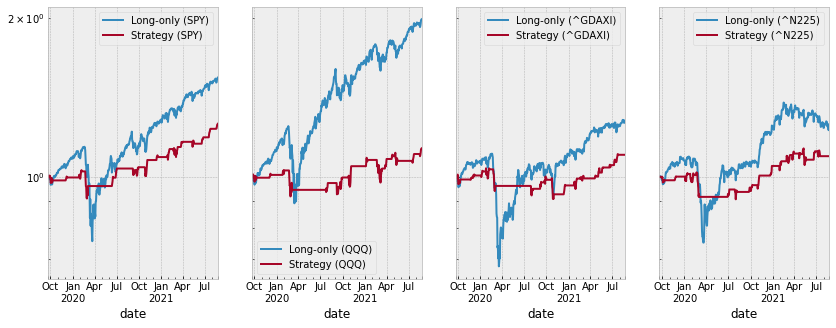

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

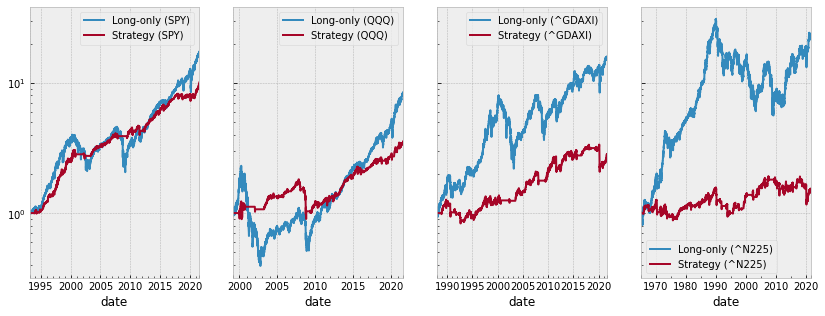

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.096380,0.078019,0.091762,0.054406,0.079191,0.029877,0.052764,0.007306
Annualised vol,0.184476,0.096706,0.272300,0.143443,0.218977,0.116071,0.195842,0.103114
Sharpe ratio,0.522452,0.806768,0.336989,0.379288,0.361638,0.257403,0.269422,0.070855
Max drawdown,0.551894,0.153225,0.829639,0.503464,0.726848,0.382193,0.818712,0.404694
Calmar ratio,0.174634,0.509178,0.110605,0.108064,0.108951,0.078173,0.064448,0.018053
Skewness,-0.051624,-0.311340,0.239007,0.674470,-0.131583,-1.254243,-0.199160,-1.640807
Kurtosis,12.684303,19.093051,7.555622,34.039433,6.849772,39.537710,9.722398,49.300293
Worst return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.128281,-0.246190,-0.246190,-0.233039,-0.233039,-0.243342,-0.182423


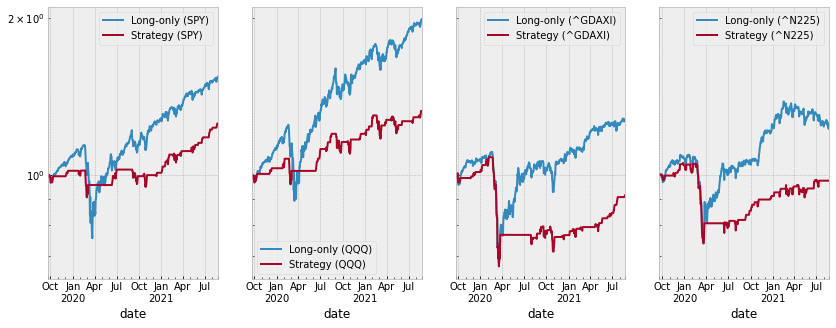

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

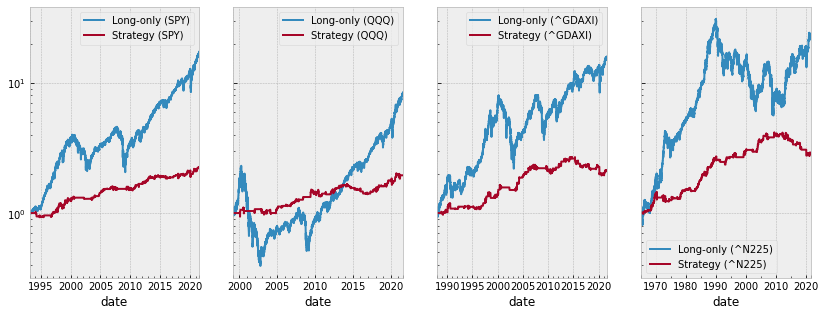

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.096380,0.027508,0.091762,0.028708,0.079191,0.021548,0.052764,0.018011
Annualised vol,0.184476,0.059736,0.272300,0.076233,0.218977,0.063152,0.195842,0.052162
Sharpe ratio,0.522452,0.460501,0.336989,0.376579,0.361638,0.341205,0.269422,0.345288
Max drawdown,0.551894,0.111611,0.829639,0.166739,0.726848,0.280084,0.818712,0.341473
Calmar ratio,0.174634,0.246467,0.110605,0.172171,0.108951,0.076934,0.064448,0.052745
Skewness,-0.051624,-0.852831,0.239007,-0.510701,-0.131583,-0.283331,-0.199160,-2.445774
Kurtosis,12.684303,54.352385,7.555622,33.101783,6.849772,29.363592,9.722398,105.620333
Worst return,-0.109424,-0.072474,-0.119788,-0.054422,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.054422,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.106961,-0.233039,-0.124379,-0.243342,-0.127345


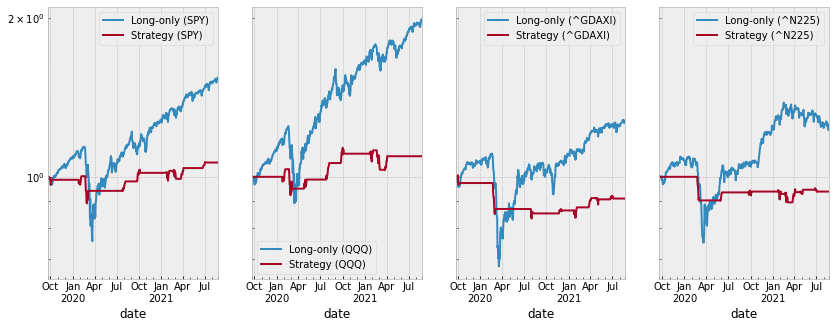

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 26-Aug-2021 06:57
